## Cài đặt các thư viện cần thiết

1. Vui lòng sử dụng Jupyter Notebook bằng Anaconda để tối ưu hóa hiệu suất của file này.
2. Nếu môi trường của bạn không có sẵn package imblearn, vui lòng gõ thêm lệnh này ở cell mới để cài đặt

__`pip install imblearn`__

In [1]:
import pickle
import pandas as pd
from datetime import date
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Nhập dữ liệu từ file.

1. Nếu bạn chưa có sẵn tập dữ liệu này, vui lòng tải nó tại đây: 
    https://www.kaggle.com/datasets/wordsforthewise/lending-club/data

2. Vui lòng đặt file jupyter này và file csv của tập dữ liệu chung một địa chỉ thư mục

In [2]:
acp = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory = False)

## Chuẩn bị dữ liệu

1. Tạo một bản sao chép với tập dữ liệu gốc.
2. Chuyển đổi thuộc tính __`issue_d`__ (Thời gian bắt đầu được nhận tiền vay) để phân hoạch thời gian

Lưu ý: Phiên bản mới của datetime đang gặp lỗi khi convert dữ liệu. Để mô hình chạy đúng nhất, vui lòng downgrade xuống phiên bản 1.7

In [3]:
sample = acp.copy() 
sample.issue_d = pd.to_datetime(sample.issue_d)

3. Chỉ lấy các hồ sơ được đồng ý cho vay từ 1.1.2015 đến 31.12.2018
4. Chỉ lấy các hồ sơ của khách hàng đã hết kì hạn vay

In [4]:
sample = sample[(sample.issue_d >= pd.to_datetime(date(2015,1,1))) & (sample.issue_d <= pd.to_datetime(date(2018,12,31)))]
sample = sample[sample.loan_status != 'Current']
sample.shape

(927931, 151)

5. Trước khi xây dựng mô hình, loại bỏ toàn bộ các biến CHEAT, biến RỖNG. Ta sẽ chỉ lấy các biến độc lập cần thiết sau đây:
- __`Loan_amnt`__: số tiền cho vay
- __`Term`__: kì hạn vay
- __`Int_rate`__: lãi suất kì hạn
- __`Dti`__: tỉ lệ nợ trên thu nhập
- __`Loan_status`__: tình trạng khoản vay (không thể trả và đã trả được)
- __`Pub_rec`__: số lượng hồ sơ công khai (tín dụng xấu, khởi kiện)
- __`Application_type`__: bên vay (cá nhân/ tập thể)
- __`fico_range_low`__:  điểm tín dụng cao nhất của người vay
- __`fico_range_high`__: điểm tín dụng thấp nhất của người vay

Từ hai biến fico, chúng ta có thể tính trung bình ra điểm tín dụng FICO trung bình của đối tượng

In [5]:
sample = sample[['loan_amnt', 'term', 'int_rate', 'dti', 'loan_status', 
                 'pub_rec', 'application_type','fico_range_low','fico_range_high',]] 

sample['FICOscore'] = (sample['fico_range_low'] + sample['fico_range_high']) / 2

6. Ta đặt một biến phụ thuộc là __'Valid'__. Tình trạng khoản vay là "Đã Trả" sẽ đặt __'Valid'__ thành 1, còn lại thành 0

In [6]:
sample['valid'] = 0
sample.loc[sample.loan_status == 'Fully Paid', 'valid'] = 1 
sample.loc[sample.loan_status == 'Late (16-30 days)', 'valid'] = 1
sample.loc[sample.loan_status == 'In Grace Period', 'valid'] = 1

7. Do 2 biến __'Application_type'__ và __'Term'__ là biến định tính. Nên chúng ta sẽ phải One-hot encoding chúng thành các bảng riêng biệt

In [7]:
sample = pd.get_dummies(sample, columns = ['term'])
sample = pd.get_dummies(sample, columns = ['application_type'])

8. Sử dụng lệnh kiểm tra, có thể thấy một vài ô của cột __`dti`__ vẫn đang bị trống. Do con số rất nhỏ so với tập dữ liệu nên ta sẽ bỏ qua chúng.

In [8]:
sample.isna().sum()

loan_amnt                        0
int_rate                         0
dti                            412
loan_status                      0
pub_rec                          0
fico_range_low                   0
fico_range_high                  0
FICOscore                        0
valid                            0
term_ 36 months                  0
term_ 60 months                  0
application_type_Individual      0
application_type_Joint App       0
dtype: int64

In [9]:
sample = sample[~sample.dti.isna()]

9. Loại bỏ các cột không cần thiết còn lại trước khi huấn luyện mô hình

In [10]:
sample = sample.drop(columns=['loan_status','fico_range_high','fico_range_low'], axis = 1)

## Huấn luyện mô hình

1. Tạo biến để áp vào mô hình. Sử dụng StandardScaler để chuẩn hóa dữ liệu tập train.
- Ta nhận thấy sự phân phối của khách hàng __'Valid = 1'__ "Trả được nợ" nhiều hơn hẳn so với khách hàng __'Valid = 0'__ "Chưa trả được nợ"

In [11]:
x = sample.drop(columns=['valid'], axis = 1)
y = sample['valid']

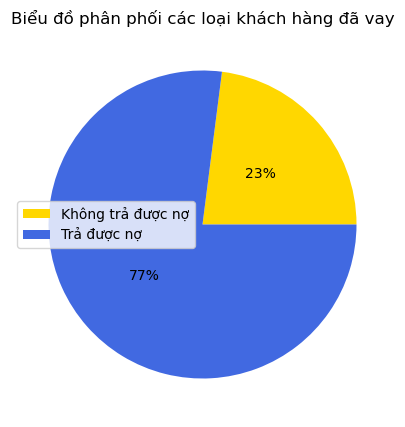

In [12]:
temp = sample.valid.value_counts()
values = [temp.loc[0], temp.loc[1]]
labels = ["Không trả được nợ", "Trả được nợ"]

plt.figure(figsize=(10,5))
plt.pie(values, colors=["gold", "royalblue"],autopct='%1.0f%%', pctdistance=0.5)
plt.legend(labels)
plt.title("Biểu đồ phân phối các loại khách hàng đã vay")
plt.show()

2. Điều chỉnh lại tỉ lệ người trả được nợ và không trả được nợ là (2:1) bằng RandomUnderSampler.
3. Chia tập dữ liệu thành 70% Train, 30% Test.
4. Huấn luyện mô hình

In [13]:
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=100) 
x_resampled, y_resampled = rus.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=150) 
model = LogisticRegression(max_iter=5000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

## Đánh giá kết quả mô hình

In [23]:
predictions = model.predict(x_test)
print('Accuracy score:', accuracy_score(y_test, predictions))
precision = precision_score(y_test, predictions)
print("Precision:", precision)
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 5)

Accuracy score: 0.6930575901491495
Precision: 0.7107533907775735
Confusion matrix:
[[ 16555  47365]
 [ 11513 116388]]


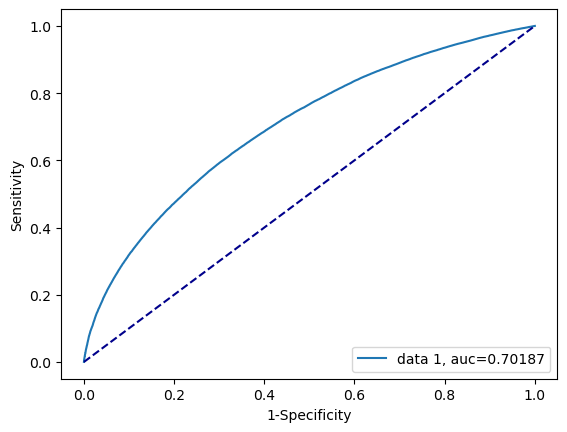

In [24]:
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0,1],[0,1],color = 'darkblue', linestyle='--')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc=4)
plt.show()

In [25]:
target_names = ['khong tra duoc no', 'tra duoc no']
print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

khong tra duoc no       0.59      0.26      0.36     63920
      tra duoc no       0.71      0.91      0.80    127901

         accuracy                           0.69    191821
        macro avg       0.65      0.58      0.58    191821
     weighted avg       0.67      0.69      0.65    191821



## Sản phẩm đầu ra

1. Lưu lại mô hình vừa huấn luyện

In [26]:
filename = 'model2.sav'
pickle.dump(model, open(filename, 'wb')) 

2. Mở lại mô hình vừa lưu để kiểm tra

In [17]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

LogisticRegression(max_iter=5000)

Link raw sản phẩm đầu ra: https://colab.research.google.com/drive/1E4T01RVeTQaJ-DiorfeKcaMmrqb51W2z#scrollTo=8E34AMOeId6k